# 0. Overview

This notebook reproduces and analyzes Derakhshani et al.'s **Bayesian Prompt Learning (BPL) for Image-Language Model Generalization**, a variational formulation of prompt learning for CLIP that learns a distribution over prompt residuals and averages predictions over samples at inference.

I implement the end-to-end pipeline in a single sequential Colab for readability; most components are written from scratch (zero-shot CLIP, CoOp, dataset split, training/evaluation), while the Bayesian prompt learner’s KL/sampling components are adapted from the original BPL repo.

# 1. Setup and Imports

In [ ]:
# Install clip and its dependencies
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-u99ef76n
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-u99ef76n
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=7b5b35e1fbda8ff121e34d5564f6cc623163821c06d971c482cfdbc202924987
  Stored in directory: /tmp/pip-ephem-wheel-cache-5d16i98m/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import clip

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

from pkg_resources import packaging
from IPython.display import display

/tmp/ipython-input-1529451825.py:15: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def visualize_dataset(dataset, num_images=5):
    # CLIP normalization parameters
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to(device)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to(device)

    def denormalize(tensor, mean, std):
        # tensor: [3, H, W]
        t_out = tensor.clone().detach()
        # Perform inplace operations on the device
        for t, m, s in zip(t_out, mean, std):
            t.mul_(s).add_(m)
        return t_out

    # Display dataset info
    print(dataset)

    plt.figure(figsize=(15, 8))

    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]

        # Move image to GPU to match mean/std
        image = image.to(device)

        # Denormalize on GPU
        image = denormalize(image, mean, std)

        # Move back to CPU and convert to numpy for plotting
        image_np = image.permute(1, 2, 0).cpu().numpy()

        # Original Image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image_np)
        plt.title(f"Class: {dataset.classes[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def make_fewshot_subset(dataset, shots_per_class, seed = 0):
    labels = dataset._labels
    n_classes = len(dataset.classes)
    g = torch.Generator().manual_seed(seed)

    subset_indices = []
    for c in range(n_classes):
        # Retrieve indices of samples where label == c
        cls_indices = [i for i, y in enumerate(labels) if y == c]
        cls_indices = torch.tensor(cls_indices) # index in original dataset

        # Randomly shuffle the class indices
        shuffle = torch.randperm(len(cls_indices), generator=g) # index in cls_indices

        # Pick indices to add to subset depending on # of shots per class
        selected = cls_indices[shuffle[:shots_per_class]]
        subset_indices.extend(selected.tolist())

    return Subset(dataset, subset_indices)

# 2. Dataset and Experimental Setting

In [ ]:
# Load the CLIP model from https://github.com/openai/CLIP/blob/main/clip/model.py
model_name = "ViT-B/16"
model, preprocess = clip.load(model_name, device = device)

100%|████████████████████████████████████████| 335M/335M [00:01<00:00, 246MiB/s]


In [ ]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        224,
        scale=(0.08, 1.0),  # Default scale range from Dassl
        interpolation=transforms.InterpolationMode.BICUBIC
    ),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    )
])

In [ ]:
# Load the FGVCAircraft test dataset
train_dataset = datasets.FGVCAircraft(
    root=os.path.expanduser("~/.cache"),
    download=True,
    split = "train",
    transform=train_transform)

val_dataset = datasets.FGVCAircraft(
    root=os.path.expanduser("~/.cache"),
    download=True,
    split = "val",
    transform=preprocess)

test_dataset = datasets.FGVCAircraft(
    root=os.path.expanduser("~/.cache"),
    download=True,
    split = "test",
    transform=preprocess)

100%|██████████| 2.75G/2.75G [02:14<00:00, 20.4MB/s]


Dataset FGVCAircraft
    Number of datapoints: 3333
    Root location: /root/.cache
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               <function _convert_image_to_rgb at 0x7d3f3977db20>
               ToTensor()
               Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
           )


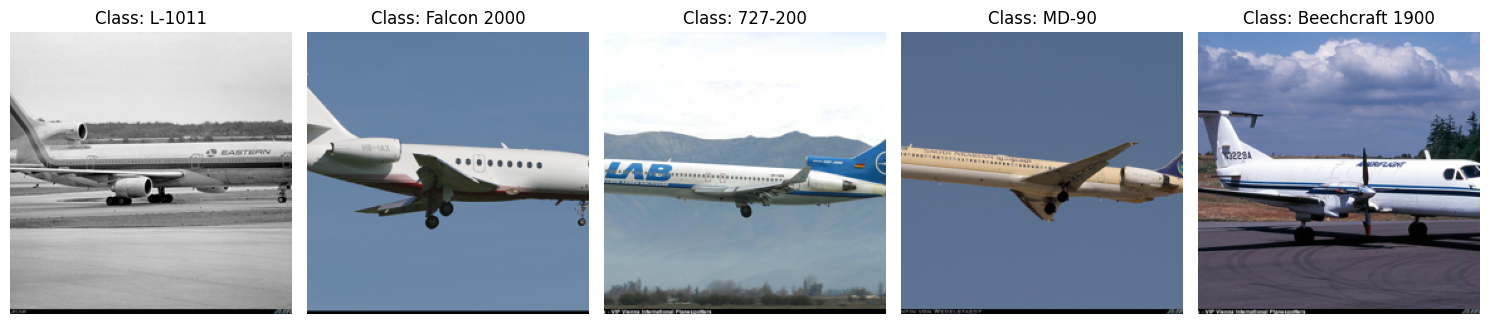

In [ ]:
# Visualize the dataset
visualize_dataset(test_dataset)

# 3. Zero-shot CLIP Baseline

In [ ]:
# Tokenize the prompts
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in test_dataset.classes]).to(device)

# Pass the prompts through the CLIP text encoder
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

# Normalize the text embeddings
text_features /= text_features.norm(dim=-1, keepdim=True)

In [ ]:
# Explanation of CLIP text encoder steps
print(f"We start with {len(text_inputs)} prompts, one for each class")
print(f"We then tokenize the collection of prompts before passing them to the CLIP text encoder to get normalized text embeddings.")
print("For instance, the first prompt is:", [(f"a photo of a {c}") for c in test_dataset.classes][0])
print(f"In tokenized form it becomes:")
print(text_inputs[0])
print(f"Finally, the CLIP encoder outputs a text embedding with shape {text_features[0].shape}")

We start with 100 prompts, one for each class
We then tokenize the collection of prompts before passing them to the CLIP text encoder to get normalized text embeddings.
For instance, the first prompt is: a photo of a 707-320
In tokenized form it becomes:
tensor([49406,   320,  1125,   539,   320,   278,   271,   278,   268,   274,
          273,   271, 49407,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0',
       dtype=torch.int32)
Finally, the CLIP encoder outputs a text embedding with shape torch.Size([512])


In [ ]:
# Perform zero-shot image classification on FGVCAircraft with the CLIP model
model.eval()
num_correct = 0
num_total = 0

loader = DataLoader(
    test_dataset,
    batch_size=1024,
    shuffle=False,
    num_workers=8,
    drop_last=False,
    pin_memory=True if device == "cuda" else False,
)

with torch.no_grad():
    for images,labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarity = 100.0 * image_features @ text_features.T # [batch_size, # of classes]
        probs = similarity.softmax(dim=-1)

        prediction = probs.argmax(dim=-1) # [batch_size]

        num_correct += (prediction == labels).sum().item()
        num_total += labels.size(0)
        print(f"The number of correct predictions is {num_correct}/{num_total}")

accuracy = num_correct/num_total
print(f"The accuracy is {accuracy}")

The number of correct predictions is 148/1024
The number of correct predictions is 409/2048
The number of correct predictions is 698/3072
The number of correct predictions is 767/3333
The accuracy is 0.2301230123012301


# 4. CoOp: Context Optimization (Zhou et al.) - Training a learnable prompt vector


In [ ]:
class PromptLearner(nn.Module):
    def __init__(self, classnames, clip_model, n_tokens, device):
        super().__init__()
        self.device = device # "gpu" or "cpu"
        self.classnames = classnames
        self.clip_model = clip_model
        self.n_tokens = n_tokens # number of tokens per prompt (equivalent to CoOp's n_ctx)
        self.d_token = clip_model.token_embedding.weight.shape[1] # usually 512
        self.n_classes = len(classnames)
        self.dtype = clip_model.dtype

        # Randomly initialize the learnable continuous prompt which is a sequence of tokens
        # optimizer will update this via gradient descent
        self.learnable_prompt = nn.Parameter(
            torch.randn(self.n_tokens, self.d_token, device=self.device, dtype=self.dtype) * 0.02
            )

        # Generate the text prompts in form "X X .... X X {class}"
        prompt_prefix = " ".join(["X"] * n_tokens)
        prompts = [prompt_prefix + " " + name + "." for name in self.classnames]

        print(f"Initial context: {prompt_prefix}")
        print(f"Number of context words (tokens): {n_tokens}")
        # print(f"The prompts are: {prompts}")

        # Turn each text prompt into a sequence of token_ids
        # tokenized_prompts.shape = [n_classes, n_ctx] where n_ctx as defined by CLIP repo is the context length of the clip model (i.e. 77).
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts])

        # print(f"The tokenized prompts are: {tokenized_prompts}")
        print(f"The shape of the tokenized prompts is: {tokenized_prompts.shape}")

        # Convert each token ID in the tokenized prompt sequence to 512-d embedding vector
        with torch.no_grad():
            input_embeddings = self.clip_model.token_embedding(
                tokenized_prompts.to(self.device)
            ) #[n_classes, n_ctx, d_token]

        n_classes, n_ctx, d_token = input_embeddings.shape
        assert d_token == self.d_token
        print(f"The shape of the input embeddings is: {input_embeddings.shape}")

        # Start of token sequence
        self.register_buffer("learnable_prompt_prefix", input_embeddings[:, :1, :])

        # Class + end of token sequence
        self.register_buffer("learnable_prompt_suffix", input_embeddings[:, 1 + self.n_tokens: , :])

        self.register_buffer("tokenized_prompts", tokenized_prompts)

    def forward(self):
        # Duplicate learnable prompt tensor to match number of classes
        learnable_prompt = self.learnable_prompt # [n_tokens, d_token]
        if learnable_prompt.ndim == 2:
            learnable_prompt = learnable_prompt.unsqueeze(0).expand(self.n_classes, -1, -1) # [n_classes, n_tokens, d_token]
        prefix = self.learnable_prompt_prefix # [n_classes, 1, d_token]
        suffix = self.learnable_prompt_suffix # [n_classes, n_ctx - n_tokens - 1, d_token]

        # Replace "X X ... X X" embeddings with the randomly initialize learnable prompt
        # x are the input embeddings to be fed into the text encoder
        x = torch.cat([prefix, learnable_prompt, suffix], dim = 1).type(self.dtype)


        # This section is from CLIP's GitHub repo encode_text method in model.py
        # add positional embedding
        x = x + self.clip_model.positional_embedding.type(self.dtype)

        # transformer expects [seq_len, batch, dim]
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.clip_model.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        # final layernorm
        x = self.clip_model.ln_final(x).type(self.dtype)

        # pick features from the EOT embedding (same trick as encode_text)
        tokenized = self.tokenized_prompts.to(self.device)     # [n_classes, n_ctx]
        eot_indices = tokenized.argmax(dim=-1)                  # [n_classes]
        x = x[torch.arange(x.shape[0]), eot_indices]            # [n_classes, d_token]

        # project to joint (image,text) space
        x = x @ self.clip_model.text_projection

        # IMPORTANT: no normalization here, to mirror encode_text
        return x   # unnormalized text features, like encode_text # [n_classes, 1024]


In [ ]:
def eval_with_prompt(prompt_learner, model, dataloader, device, label_offset = 0):
    prompt_learner.eval()
    model.eval()
    logit_scale = model.logit_scale.exp()

    with torch.no_grad():
        text_feats = prompt_learner()  # [n_classes, 1024]
        text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)


            img_feats = model.encode_image(images)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

            logits = logit_scale * img_feats @ text_feats.t()
            preds = logits.argmax(dim=-1)

            # Map global labels -> local 0..(K-1)
            labels_local = labels - label_offset

            # print(preds)
            # print(labels_local)
            # print(labels)

            correct += (preds == labels_local).sum().item()
            total += labels_local.size(0)

    return correct / total

In [ ]:
# Based off subsample_classes function in https://github.com/saic-fi/Bayesian-Prompt-Learning/blob/main/datasets/oxford_pets.py
def split_base_new(dataset):
    """
    Split a FGVCAircraft dataset into two subsets based on class labels.

    Assumes:
      - dataset._labels exists
      - len(dataset._labels) == len(dataset)
      - labels are integers

    Classes are sorted and split into two halves:
      - base = first half  (gets the extra one if odd)
      - new  = second half

    Returns:
        base_subset  : torch.utils.data.Subset
        new_subset   : torch.utils.data.Subset
        base_classes : list[int] (sorted)
        new_classes  : list[int] (sorted)
    """
    labels = list(dataset._labels)

    # unique sorted class labels
    all_classes = sorted(set(labels))
    n_classes = len(all_classes)
    if n_classes < 2:
        raise ValueError(f"Need at least 2 classes, found {n_classes}")

    # split into two halves
    m = math.ceil(n_classes / 2)
    base_classes = all_classes[:m]
    new_classes = all_classes[m:]

    base_set = set(base_classes)
    new_set = set(new_classes)

    # print(f"base_classes: {base_classes}")
    # print(f"new_classes: {new_classes}")

    base_indices = []
    new_indices = []

    for idx, y in enumerate(labels):
        if y in base_set:
            base_indices.append(idx)
        elif y in new_set:
            new_indices.append(idx)
        # else: shouldn't happen

    base_subset = Subset(dataset, base_indices)
    new_subset = Subset(dataset, new_indices)

    return base_subset, new_subset

In [ ]:
# Hyperparameters for CoOp
train_batch_size = 32
val_batch_size = 100
test_batch_size = 100
seed = 2
num_workers = 8
n_tokens = 4
shots_per_class = 16  # or 1, 2, 8, 16, etc.
base_lr = 0.002 # as in CoOp
num_epochs = 25
base2new = True

In [ ]:
# Freeze CLIP
for p in model.parameters():
    p.requires_grad_(False)

In [ ]:
# Build few-shot training dataset
fewshot_train_dataset = make_fewshot_subset(
    train_dataset,
    shots_per_class=shots_per_class,
    seed=seed,
)

print("Few-shot train size:", len(fewshot_train_dataset))  # should be number_of_classes * shots_per_class

# Split the training, validation and testing set in two for generalization task
# During training, the model is shown half of the classes in the dataset (base)
# During eval, the model is tested on the other half of the classes it was not trained on (new)
if base2new:
    # Split the dataset at the midpoint because the fewshot training set created by us is already ordered in ascending order by class
    m = len(fewshot_train_dataset) // 2
    indices_base= fewshot_train_dataset.indices[:m]
    indices_new = fewshot_train_dataset.indices[m:]

    base_train_dataset = Subset(fewshot_train_dataset.dataset, indices_base)
    new_train_dataset = Subset(fewshot_train_dataset.dataset, indices_new)

    base_val_dataset, new_val_dataset = split_base_new(val_dataset)
    base_test_dataset, new_test_dataset = split_base_new(test_dataset)

    base_classes = base_train_dataset.dataset.classes[:len(base_train_dataset.dataset.classes)//2]
    new_classes = base_train_dataset.dataset.classes[len(base_train_dataset.dataset.classes)//2:]

    # print(f"Base_train_dataset size: {len(base_train_dataset)}")
    # print(f"New_train_dataset size: {len(new_train_dataset)}")
    # print(f"Base_val_dataset size: {len(base_val_dataset)}")
    # print(f"New_val_dataset size: {len(new_val_dataset)}")
    # print(f"Base_test_dataset size: {len(base_test_dataset)}")
    # print(f"New_test_dataset size: {len(new_test_dataset)}")

    train_loader = DataLoader(
        base_train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )

    val_loader = DataLoader(
        base_val_dataset,
        batch_size=val_batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )

    test_loader = DataLoader(
        base_test_dataset,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )

    new_test_loader = DataLoader(
        new_test_dataset,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )

else:
    train_loader = DataLoader(
        fewshot_train_dataset, # loading the few-shot training dataset
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=val_batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )

Few-shot train size: 1600


In [ ]:
# Train the prompt learner
if base2new:
    prompt_learner = PromptLearner(
        base_classes, model, n_tokens=n_tokens, device=device
        ).to(device)
else:
    prompt_learner = PromptLearner(
        train_dataset.classes, model, n_tokens=n_tokens, device=device
        ).to(device)

optimizer = torch.optim.SGD(
    prompt_learner.parameters(),
    lr=base_lr,
    momentum=0.9)

scheduler = CosineAnnealingLR(
    optimizer,
    T_max=num_epochs,  # number of steps for cosine decay
)

logit_scale = model.logit_scale.exp()

# Pre-training test accuracy (i.e. random prompt)
acc_before = eval_with_prompt(prompt_learner, model, test_loader, device)
print(f"Test accuracy BEFORE training: {acc_before:.3f}")

# Training loop
for epoch in range(num_epochs):
    prompt_learner.train()
    running_loss = 0.0
    n_batches = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            img_feats = model.encode_image(images)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

        text_feats = prompt_learner()
        text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)

        logits = logit_scale * img_feats @ text_feats.t()
        loss = F.cross_entropy(logits, labels)

        running_loss += loss.item()
        n_batches += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()

    # Metrics
    print(f"Epoch {epoch+1}: loss = {running_loss / n_batches:.4f}")
    if epoch % 10 == 0:
        val_acc  = eval_with_prompt(prompt_learner, model, val_loader, device)
        print(f"Validation accuracy: {val_acc}")

# Post-training test accuracy
test_acc  = eval_with_prompt(prompt_learner, model, test_loader, device)
print(f"Test accuracy AFTER training: {test_acc}")

Initial context: X X X X
Number of context words (tokens): 4
The shape of the tokenized prompts is: torch.Size([50, 77])
The shape of the input embeddings is: torch.Size([50, 77, 512])
Test accuracy BEFORE training: 0.140
Epoch 1: loss = 2.5946
Validation accuracy: 0.29934013197360526
Epoch 2: loss = 2.3171
Epoch 3: loss = 2.2739
Epoch 4: loss = 2.2738
Epoch 5: loss = 2.2093
Epoch 6: loss = 2.2225
Epoch 7: loss = 2.1953
Epoch 8: loss = 2.1620
Epoch 9: loss = 2.1518
Epoch 10: loss = 2.1325
Epoch 11: loss = 2.1686
Validation accuracy: 0.34073185362927416
Epoch 12: loss = 2.1423
Epoch 13: loss = 2.1632
Epoch 14: loss = 2.1255
Epoch 15: loss = 2.0779
Epoch 16: loss = 2.1218
Epoch 17: loss = 2.1112
Epoch 18: loss = 2.0605
Epoch 19: loss = 2.0527
Epoch 20: loss = 2.0880
Epoch 21: loss = 2.0449
Validation accuracy: 0.34913017396520696
Epoch 22: loss = 2.1005
Epoch 23: loss = 2.1125
Epoch 24: loss = 2.0269
Epoch 25: loss = 2.1346
Test accuracy AFTER training: 0.3469387755102041


## 4.1 Generalization of CoOp to unseen classes

In [ ]:
# Evaluation harness for the generalization task on unseen classes
class NewPromptLearner(PromptLearner):
    def __init__(self, classnames, clip_model, n_tokens, device, shared_prompt):
        """
        classnames   : list of NEW class names (unseen during training)
        shared_prompt: tensor from the trained base PromptLearner.learnable_prompt
                       shape [n_tokens, d_token]
        """
        # Build all class-dependent buffers (prefix/suffix/tokenized) for NEW classes
        super().__init__(classnames, clip_model, n_tokens, device)

        # Replace randomly initialized learnable_prompt with the shared one
        shared_prompt = shared_prompt.to(device=device, dtype=self.dtype)

        assert shared_prompt.shape == (self.n_tokens, self.d_token), \
            f"shared_prompt shape {shared_prompt.shape} " \
            f"!= ({self.n_tokens}, {self.d_token})"

        # Use it as a parameter but with gradients off (strict split, no training)
        self.learnable_prompt = nn.Parameter(shared_prompt, requires_grad=False)

        # Extra safety: ensure there are no trainable params at all in this module
        for p in self.parameters():
            p.requires_grad = False

In [ ]:
# Sanity check of the learned prompts being passed to the evaluation harness
shared_prompt = prompt_learner.learnable_prompt.detach()
print(shared_prompt)

tensor([[ 0.0084, -0.0141,  0.0053,  ...,  0.0591,  0.0349, -0.0264],
        [-0.0002, -0.0480,  0.0323,  ..., -0.0285,  0.0061,  0.0441],
        [ 0.0405, -0.0212,  0.0376,  ...,  0.0309, -0.0124, -0.0427],
        [ 0.0493,  0.0336,  0.0195,  ..., -0.0632,  0.0134, -0.0117]],
       device='cuda:0', dtype=torch.float16)


In [ ]:
new_prompt_learner = NewPromptLearner(
    classnames=new_classes,
    clip_model=model,
    n_tokens=n_tokens,
    device=device,
    shared_prompt=shared_prompt,
).to(device)

Initial context: X X X X
Number of context words (tokens): 4
The shape of the tokenized prompts is: torch.Size([50, 77])
The shape of the input embeddings is: torch.Size([50, 77, 512])


In [ ]:
new_test_acc  = eval_with_prompt(new_prompt_learner, model, new_test_loader, device, label_offset=len(base_classes))
print(f"Test acc on unseen classes: {new_test_acc}")

Test acc on unseen classes: 0.3011397720455909


# 5. BPL: Bayesian Prompt Learning

In [ ]:
class BayesianPromptLearner(nn.Module):
    def __init__(self, classnames, clip_model, n_tokens, device, n_samples=1):
        super().__init__()
        self.device = device
        self.n_samples = n_samples  # Number of MC samples (L in the repo)
        self.classnames = classnames
        self.clip_model = clip_model
        self.n_tokens = n_tokens
        self.d_token = clip_model.token_embedding.weight.shape[1]
        self.dtype = clip_model.dtype

        # --- 1. Base Context (Deterministic) ---
        # Similar to your original code, we initialize the base context 'ctx'
        # In the repo, this is self.ctx
        self.ctx = nn.Parameter(
            torch.randn(self.n_tokens, self.d_token, device=self.device, dtype=self.dtype) * 0.02
        ) # (n_tokens, d_token)

        # --- 2. Bayesian Parameters (Unconditional) ---
        # We learn a distribution for a bias vector that shifts the context
        # Shape is (1, d_token) -> shared across all tokens in the sequence
        self.mean_posterior = nn.Parameter(torch.zeros(1, self.d_token, device=self.device, dtype=self.dtype))
        # Initialize log variance (using repo's style of random init)
        self.logvar_posterior = nn.Parameter(torch.rand(1, self.d_token, device=self.device, dtype=self.dtype))

        # --- Text Prompt Setup (Prefix/Suffix) ---
        # Same as your code
        prompt_prefix = " ".join(["X"] * n_tokens)
        prompts = [prompt_prefix + " " + name + "." for name in self.classnames]
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts])

        with torch.no_grad():
            input_embeddings = self.clip_model.token_embedding(tokenized_prompts.to(self.device))

        self.register_buffer("prefix", input_embeddings[:, :1, :])
        self.register_buffer("suffix", input_embeddings[:, 1 + self.n_tokens:, :])
        self.register_buffer("tokenized_prompts", tokenized_prompts)

    def sample(self, mu, logvar):
        # Reparameterization trick
        # Output shape: (L, 1, d_token)
        shape = (self.n_samples,) + mu.size()
        # print(f"sample shape: {shape}")
        eps = torch.randn(shape).to(self.device).type(self.dtype)
        bias = mu.unsqueeze(0) + eps * logvar.exp().sqrt().unsqueeze(0)
        return bias

    def forward(self):
        # 1. Sample Bias (equivalent to the residual r in the paper)
        # bias: (L, 1, d_token)
        bias = self.sample(self.mean_posterior, self.logvar_posterior)

        # 2. Add Bias to Context
        # ctx: (n_tokens, d_token) -> (1, n_tokens, d_token)
        ctx = self.ctx.unsqueeze(0)
        # ctx_shifted: (L, n_tokens, d_token)
        ctx_shifted = ctx + bias
        # print(f"ctx.shape: {ctx.shape}")
        # print(f"ctx_shifted.shape: {ctx_shifted.shape}")

        # 3. Construct Prompts for all classes
        # We need to replicate this for each class
        # prefix: (n_classes, 1, d_token)
        # suffix: (n_classes, *, d_token)

        # Output list of text features
        text_features_list = []

        # We process each sample L individually or use broadcasting
        for i in range(self.n_samples):
            # specific context for this sample: (n_tokens, d_token)
            current_ctx = ctx_shifted[i]

            # Expand to number of classes: (n_classes, n_tokens, d_token)
            current_ctx_expanded = current_ctx.unsqueeze(0).expand(len(self.classnames), -1, -1)

            # Concat: [Prefix, Context, Suffix]
            # (n_classes, n_ctx, d_token)
            prompts = torch.cat(
                [self.prefix, current_ctx_expanded, self.suffix],
                dim=1
            ).type(self.dtype)

            # print(f"prompts.shape before text encoder: {prompts.shape}")

            # Pass through CLIP Text Encoder
            x = prompts + self.clip_model.positional_embedding.type(self.dtype)
            x = x.permute(1, 0, 2)  # NLD -> LND
            x = self.clip_model.transformer(x)
            x = x.permute(1, 0, 2)  # LND -> NLD
            x = self.clip_model.ln_final(x).type(self.dtype)

            # print(f"x.shape after text encoder: {x.shape}")

            tokenized = self.tokenized_prompts
            # print(f"tokenized.shape: {tokenized.shape}")
            x = x[torch.arange(x.shape[0]), tokenized.argmax(dim=-1)] @ self.clip_model.text_projection
            # print(f"x.shape after upprojection: {x.shape}")
            text_features_list.append(x)

        # Stack to (L, n_classes, feature_dim)
        return torch.stack(text_features_list), self.mean_posterior, self.logvar_posterior

In [ ]:
def eval_with_prompt(prompt_learner, model, dataloader, device, label_offset = 0, debug=False):
    prompt_learner.eval()
    model.eval()
    logit_scale = model.logit_scale.exp()

    # 1. Get Text Features (L samples)
    with torch.no_grad():
        # text_feats: [L, n_classes, dim]
        text_feats, _, _ = prompt_learner()
        # Normalize
        text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # 2. Get Image Features
            img_feats = model.encode_image(images)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

            # Expand image features for broadcasting: [L, Batch, Dim]
            # We repeat the image features L times to match the L text feature samples
            L = text_feats.shape[0]
            img_feats_expanded = img_feats.unsqueeze(0).expand(L, -1, -1)

            # 3. Compute Logits for each sample
            # [L, Batch, Dim] @ [L, Dim, n_classes] -> [L, Batch, n_classes]
            # Note: text_feats.transpose(1, 2) makes it [L, Dim, n_classes]
            logits = logit_scale * torch.einsum("lbd,lcd->lbc", img_feats_expanded, text_feats)

            # 4. Compute Softmax Probabilities
            probs = torch.softmax(logits, dim=-1) # [L, Batch, n_classes]

            # 5. Average probabilities across L samples (Monte Carlo approximation)
            mean_probs = probs.mean(dim=0) # [Batch, n_classes]

            # 6. Prediction
            preds = mean_probs.argmax(dim=-1)

            # Map global labels -> local 0..(K-1)
            labels_local = labels - label_offset

            if debug:
                print(f"pred:{preds}")
                print(f"labels:{labels}")
                print(f"labels_local:{labels_local}")

            correct += (preds == labels_local).sum().item()
            total += labels_local.size(0)

    return correct / total

In [ ]:
# Hyperparameters
train_batch_size = 1
val_batch_size = 1
test_batch_size = 1
num_workers = 8
# seed determined by earlier hyperparameter setting
# shots per class determined by earlier hyperparameter setting

base_lr = 0.002 # as in CoOp
num_epochs = 10
n_samples = 10 # number of MC samples
n_tokens = 4 # to match config
kl_weight = 0.001        # Weight for KL divergence loss (from repo)
base2new = True

In [ ]:
# Re-initialize DataLoaders due to smaller batch sizes required to fit the Bayesian Prompt Learner model on GPU RAM
if base2new:
    train_loader = DataLoader(
        base_train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )

    val_loader = DataLoader(
        base_val_dataset,
        batch_size=val_batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )

    test_loader = DataLoader(
        base_test_dataset,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )

    new_test_loader = DataLoader(
        new_test_dataset,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )

else:
    train_loader = DataLoader(
        fewshot_train_dataset, # loading the few-shot training dataset from earlier
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=val_batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=True if device == "cuda" else False,
    )

In [ ]:
# --- Initialization ---
if base2new:
    prompt_learner = BayesianPromptLearner(
        base_classes,
        model,
        n_tokens=n_tokens,
        device=device,
        n_samples=n_samples
    ).to(device)

else:
    prompt_learner = BayesianPromptLearner(
        train_dataset.classes,
        model,
        n_tokens=n_tokens,
        device=device,
        n_samples=n_samples
    ).to(device)



optimizer = torch.optim.SGD(
    prompt_learner.parameters(),
    lr=base_lr,
    momentum=0.9)

scheduler = CosineAnnealingLR(
    optimizer,
    T_max=num_epochs,  # number of steps for cosine decay
)


logit_scale = model.logit_scale.exp()

print(f"Start training with {n_samples} MC samples per step...")

# --- Training Loop ---
for epoch in range(num_epochs):
    prompt_learner.train()
    running_loss = 0.0
    running_nll = 0.0
    running_kl = 0.0
    n_batches = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 1. Encode Images (Fixed CLIP Image Encoder)
        with torch.no_grad():
            img_feats = model.encode_image(images)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

        # 2. Encode Text (Bayesian Prompt Learner)
        # text_feats: [L, n_classes, dim]
        # mu, logvar: [1, dim] (parameters of the posterior)
        text_feats, mu, logvar = prompt_learner()
        text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)

        # 3. Compute Logits
        # Expand images to match L samples: [L, Batch, Dim]
        img_feats_expanded = img_feats.unsqueeze(0).expand(n_samples, -1, -1)

        # Compute logits: [L, Batch, n_classes]
        logits = logit_scale * torch.einsum("lbd,lcd->lbc", img_feats_expanded, text_feats)

        # 4. Compute Task Loss (Negative Log Likelihood)
        # We want log(mean(exp(log_softmax))) -> LogSumExp trick
        log_probs = torch.log_softmax(logits, dim=-1) # [L, Batch, n_classes]

        # Gather log probs for the correct class
        # labels: [Batch] -> [L, Batch, 1]
        labels_expanded = labels.unsqueeze(0).unsqueeze(-1).expand(n_samples, -1, -1)
        selected_log_probs = torch.gather(log_probs, 2, labels_expanded).squeeze(-1) # [L, Batch]

        # Log-Sum-Exp over samples to get log likelihood of data
        # loss = - log( (1/L) * sum( prob_i ) )
        #      = - ( logsumexp(log_prob_i) - log(L) )
        task_score = torch.logsumexp(selected_log_probs, dim=0) - torch.log(torch.tensor(float(n_samples)).to(device))
        nll_loss = -task_score.mean() # Average over batch

        # 5. Compute KL Divergence Loss
        # KL(q(z)||p(z)) where p(z) ~ N(0, I)
        # Analytical KL for Diagonal Gaussian
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalize KL if needed (the repo takes mean over dimensions sometimes, or sum)
        # Here we take the mean to keep scale reasonable relative to NLL
        kl_div = kl_div.mean()

        # 6. Total Loss
        loss = nll_loss + kl_weight * kl_div

        # Optimization Step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging accumulators
        running_loss += loss.item()
        running_nll += nll_loss.item()
        running_kl += kl_div.item()
        n_batches += 1

    # Step scheduler
    scheduler.step()

    # --- Logging ---
    epoch_loss = running_loss / n_batches
    epoch_nll = running_nll / n_batches
    epoch_kl = running_kl / n_batches

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} (NLL: {epoch_nll:.4f}, KL: {epoch_kl:.4f}) | LR: {optimizer.param_groups[0]['lr']:.6f}")

    # --- Evaluation every 10 epochs ---
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print("Evaluating...")
        train_acc = eval_with_prompt(prompt_learner, model, train_loader, device)
        val_acc = eval_with_prompt(prompt_learner, model, val_loader, device)
        print(f" -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# Final Evaluation
print("Training complete. Final Evaluation:")
final_test_acc = eval_with_prompt(prompt_learner, model, test_loader, device)
print(f"Final Test Acc: {final_test_acc:.4f}")

Start training with 10 MC samples per step...
Epoch 1/10 | Loss: 3.6346 (NLL: 3.5743, KL: 60.1626) | LR: 0.001951
Evaluating...
 -> Train Acc: 0.1938 | Val Acc: 0.2358
Epoch 2/10 | Loss: 2.6659 (NLL: 2.5977, KL: 68.2416) | LR: 0.001809
Epoch 3/10 | Loss: 2.5986 (NLL: 2.5266, KL: 72.0075) | LR: 0.001588
Epoch 4/10 | Loss: 2.5740 (NLL: 2.5003, KL: 73.5988) | LR: 0.001309
Epoch 5/10 | Loss: 2.5801 (NLL: 2.5058, KL: 74.4408) | LR: 0.001000
Epoch 6/10 | Loss: 2.5539 (NLL: 2.4794, KL: 74.9053) | LR: 0.000691
Epoch 7/10 | Loss: 2.5216 (NLL: 2.4471, KL: 75.0892) | LR: 0.000412
Epoch 8/10 | Loss: 2.5560 (NLL: 2.4815, KL: 75.1250) | LR: 0.000191
Epoch 9/10 | Loss: 2.5691 (NLL: 2.4946, KL: 75.1250) | LR: 0.000049
Epoch 10/10 | Loss: 2.5154 (NLL: 2.4409, KL: 75.1250) | LR: 0.000000
Evaluating...
 -> Train Acc: 0.2725 | Val Acc: 0.2873
Training complete. Final Evaluation:
Final Test Acc: 0.2983


In [ ]:
class NewBayesianPromptLearner(BayesianPromptLearner):
    def __init__(self, classnames, clip_model, n_tokens, device,
                 n_samples, shared_ctx, shared_mu, shared_logvar):
        """
        classnames   : list of NEW class names (unseen during training)
        shared_ctx   : ctx from trained base learner, shape [n_tokens, d_token]
        shared_mu    : mean_posterior from base, shape [1, d_token]
        shared_logvar: logvar_posterior from base, shape [1, d_token]
        """
        # This builds prefix/suffix/tokenized_prompts for NEW classes
        super().__init__(
            classnames=classnames,
            clip_model=clip_model,
            n_tokens=n_tokens,
            device=device,
            n_samples=n_samples,
        )

        # Copy the shared parameters from base
        shared_ctx    = shared_ctx.to(device=device, dtype=self.dtype)
        shared_mu     = shared_mu.to(device=device, dtype=self.dtype)
        shared_logvar = shared_logvar.to(device=device, dtype=self.dtype)

        assert shared_ctx.shape == self.ctx.shape, \
            f"ctx shape {shared_ctx.shape} != {self.ctx.shape}"
        assert shared_mu.shape == self.mean_posterior.shape, \
            f"mu shape {shared_mu.shape} != {self.mean_posterior.shape}"
        assert shared_logvar.shape == self.logvar_posterior.shape, \
            f"logvar shape {shared_logvar.shape} != {self.logvar_posterior.shape}"

        # Replace with shared params, but freeze them
        self.ctx = nn.Parameter(shared_ctx, requires_grad=False)
        self.mean_posterior = nn.Parameter(shared_mu, requires_grad=False)
        self.logvar_posterior = nn.Parameter(shared_logvar, requires_grad=False)

        # Extra safety: disable grads on everything
        for p in self.parameters():
            p.requires_grad = False


In [ ]:
# After BPL training on base classes finishes
base_prompt_learner = prompt_learner  # just for clarity

# Extract shared parameters (detach to break grad graph)
shared_ctx    = base_prompt_learner.ctx.detach()
shared_mu     = base_prompt_learner.mean_posterior.detach()
shared_logvar = base_prompt_learner.logvar_posterior.detach()

# Build NEW BPL learner for unseen classes
new_bpl_prompt_learner = NewBayesianPromptLearner(
    classnames=new_classes,        # list of NEW class names (50..99)
    clip_model=model,
    n_tokens=n_tokens,
    device=device,
    n_samples=n_samples,
    shared_ctx=shared_ctx,
    shared_mu=shared_mu,
    shared_logvar=shared_logvar,
).to(device)

In [ ]:
# Base accuracy (labels 0..49)
base_test_acc = eval_with_prompt(
    base_prompt_learner, model, test_loader, device, label_offset=0
)

# New accuracy (labels 50..99)
new_test_acc = eval_with_prompt(
    new_bpl_prompt_learner,
    model,
    new_test_loader,
    device,
    label_offset=len(base_classes),  # 50 for FGVC Aircraft
    debug=False,
)


## 5.1 Summary of BPL experiment results

In [ ]:
# Summary of experiment results
print("Hyperparameters")
print(f"train_batch_size: {train_batch_size}")
print(f"test_batch_size: {test_batch_size}")
print(f"num_workers: {num_workers}")
print(f"seed: {seed}")
print(f"shots per class: {shots_per_class}")
print(f"base_classes: {base_classes}")
print(f"new_classes: {new_classes}")
print(f"n_samples: {n_samples}")
print(f"n_tokens: {n_tokens}")
print(f"kl_weight: {kl_weight}")
print(f"base2new: {base2new}")
print(f"base_lr: {base_lr}")
print(f"num_epochs: {num_epochs}")
print(f"device: {device}")

print("------------------------------")
print("Performance")
print(f"BPL base acc (seen classes): {base_test_acc:.4f}")
print(f"BPL new  acc (unseen classes): {new_test_acc:.4f}")

Hyperparameters
train_batch_size: 1
test_batch_size: 1
num_workers: 8
seed: 2
shots per class: 16
base_classes: ['707-320', '727-200', '737-200', '737-300', '737-400', '737-500', '737-600', '737-700', '737-800', '737-900', '747-100', '747-200', '747-300', '747-400', '757-200', '757-300', '767-200', '767-300', '767-400', '777-200', '777-300', 'A300B4', 'A310', 'A318', 'A319', 'A320', 'A321', 'A330-200', 'A330-300', 'A340-200', 'A340-300', 'A340-500', 'A340-600', 'A380', 'ATR-42', 'ATR-72', 'An-12', 'BAE 146-200', 'BAE 146-300', 'BAE-125', 'Beechcraft 1900', 'Boeing 717', 'C-130', 'C-47', 'CRJ-200', 'CRJ-700', 'CRJ-900', 'Cessna 172', 'Cessna 208', 'Cessna 525']
new_classes: ['Cessna 560', 'Challenger 600', 'DC-10', 'DC-3', 'DC-6', 'DC-8', 'DC-9-30', 'DH-82', 'DHC-1', 'DHC-6', 'DHC-8-100', 'DHC-8-300', 'DR-400', 'Dornier 328', 'E-170', 'E-190', 'E-195', 'EMB-120', 'ERJ 135', 'ERJ 145', 'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16A/B', 'F/A-18', 'Falcon 2000', 'Falcon 900', 'Fokker 

# Diagnostics

In [ ]:
print(f"CLIP Model Parameters\n")
print(f"model.visual.input_resolution: {model.visual.input_resolution}")
print(f"model.vocab_size: {model.vocab_size}")
print(f"model.context_length: {model.context_length}")
print(f"model.token_embedding.weight.shape: {model.token_embedding.weight.shape}")
print(f"model.positional_embedding.shape: {model.positional_embedding.shape}")
print(f"model.text_projection.shape: {model.text_projection.shape}")
print(f"model.transformer.width: {model.transformer.width}")

CLIP Model Parameters

model.visual.input_resolution: 224
model.vocab_size: 49408
model.context_length: 77
model.token_embedding.weight.shape: torch.Size([49408, 512])
model.positional_embedding.shape: torch.Size([77, 512])
model.text_projection.shape: torch.Size([512, 512])
model.transformer.width: 512


In [ ]:
# Tests for few-shot dataset creation

# Proof that the fewshot_train_dataset
# for i, item in enumerate(fewshot_train_dataset):
#     print(i, item[1])
# for i, item in enumerate(base_train_dataset):
#     print(i, item[1])
# for i, item in enumerate(new_train_dataset):
#     print(i, item[1])

# # Test for make_fewshot_dataset function
# test_shots = 4
# fewshot_train = make_fewshot_subset(train_dataset, shots_per_class=test_shots )
# print(len(fewshot_train))  # should be 4 * 10 = 40 for CIFAR10

# from collections import Counter
# labels_fewshot = [fewshot_train[i][1] for i in range(len(fewshot_train))]
# print(Counter(labels_fewshot))

# images, labels = next(iter(train_loader))
# images, labels = images.to(device), labels.to(device)


# with torch.no_grad():
#     img_feats = model.encode_image(images)
#     img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

# print("image_features:", img_feats.shape)  # expect [32, D]
# print("num classes:", len(train_dataset.classes), train_dataset.classes)